<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

### **1.1.  Loggi**

A [Loggi](https://www.loggi.com/) é uma startup unicórnio brasileira de tecnologia focada em **logística**. A Loggi começou entregando apenas documentos entre 2013 e 2014. Dois anos depois, entrou no segmento de e-commerce. E, desde 2017, tem atuado nas entregas de alimentos também.

### **1.2.  Loggi BUD**

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub (link) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala.

### **1.3.  Loggi Distrito Federal**

Para este projeto, selecionamos os dados referentes aos centros de distribuição localizados na cidade de Brasília no Distrito Federal.

Através desses dados, juntamente com outros disponibilizados por orgãos públicos como citados acima, iremos realizar uma análise exploratória com objetivo de compreender melhor detalhes como distribuição de entregas por Hub e quais fatores podem ter sido levados em consideração na escolha de cada localização.



```
```

## 2\. Pacotes e bibliotecas

Instalando pacotes e importando bibliotecas que serão utilizadas no decorrer do projeto

In [1]:
!pip install mplleaflet

  Preparing metadata (setup.py) ... done
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28565 sha256=a2ba50568e9b721452d4c5f5ec93010d2250e7321b459446ae23d7b7bfd908aa
  Stored in directory: /root/.cache/pip/wheels/0d/00/a9/595e650d2e0a5ca4119c0f6e03dfd1093e5d67fe2c0e5d49f0
Successfully built mplleaflet


In [2]:
import json
import mplleaflet
import geopy
import geopandas
import folium
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import IFrame
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic


## 3\. Exploração de dados

Aqui iremos explorar os dados .json obtidos a respeito das entregas da Loggi no Distrito Federal, iremos organizar estes dados de forma que ele se torne um Dataframe de melhor utilização e organização para nossa futura análise

In [3]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [4]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)



deliveries_df = pd.DataFrame(data)



hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)



deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [5]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [6]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

Nesta etapa do projeto, iremos enriquecer nossos dados com mais informações a respeito da geolocalização de nossos Hubs e nossas entregas, também iremos realizar o trabalho de qualidade para saber qual a confiabilidade de nossos dados

In [7]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [8]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))


{
  "place_id": 13551965,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [9]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [10]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,13551965,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,13548034,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,10766946,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [11]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-11-d83d9be41f84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-11-d83d9be41f84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-11-d83d9be41f84>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [12]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [13]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [14]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [15]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [16]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [42]:
from geopy.distance import geodesic

deliveries_df['distance'] = deliveries_df.apply(
    lambda row: geodesic((row['hub_lat'], row['hub_lng']), (row['delivery_lat'], row['delivery_lng'])).kilometers,
    axis=1
)

average_distances = deliveries_df.groupby('region')['distance'].median().reset_index()

In [34]:
deliveries_count = deliveries_df.groupby(['region', 'delivery_suburb']).size().reset_index(name='count')
total_deliveries_by_hub = deliveries_count.groupby('region')['count'].sum().reset_index(name='total')

deliveries_count = deliveries_count.merge(total_deliveries_by_hub, on='region')
deliveries_count['percent'] = 100 * deliveries_count['count'] / deliveries_count['total']

## 5\. Visualização

Nesta etapa iremos utilizar um mapa do distrito federal para criar uma representação visual, distribuindo os pontos de entrega sobre o mapa assim como a localização exata de cada Hub de distribuição

In [22]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [23]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]


In [24]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))


In [25]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))


<ipython-input-26-503fe3aaf9e1>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


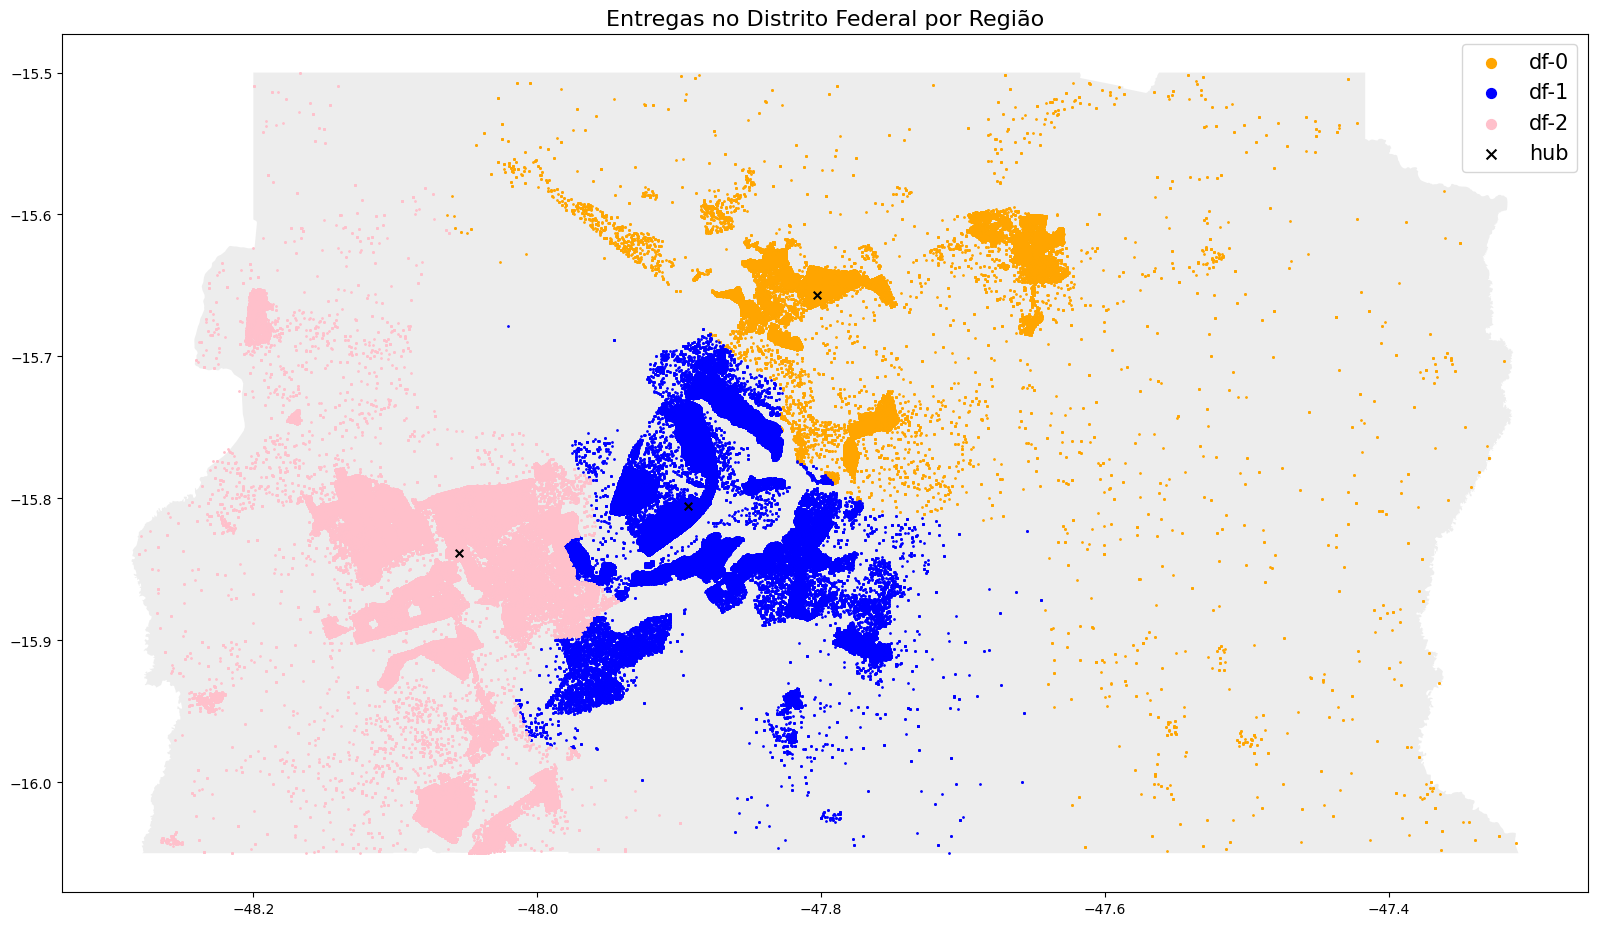

In [26]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

mapa.plot(ax=ax, alpha=0.4, color="lightgrey")


geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="orange", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="pink", label="df-2")


geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])



Aqui iremos criar a representação gráfica da proporção de entregas de cada Hub, sendo os valores em % referente ao total das entregas

<ipython-input-27-8638ed45948b>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="coolwarm")


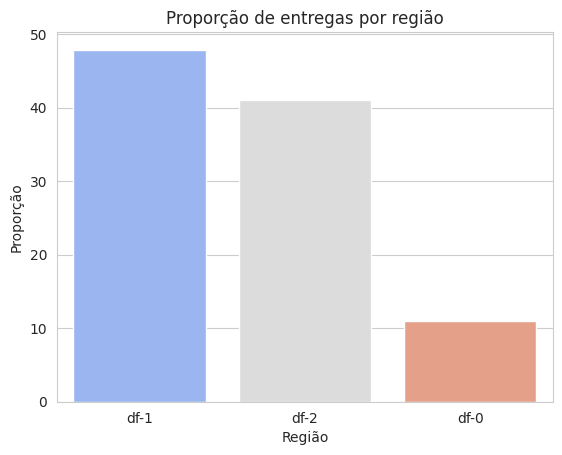

In [27]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data['region_percent'] = data['region_percent'] * 100


with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="coolwarm")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

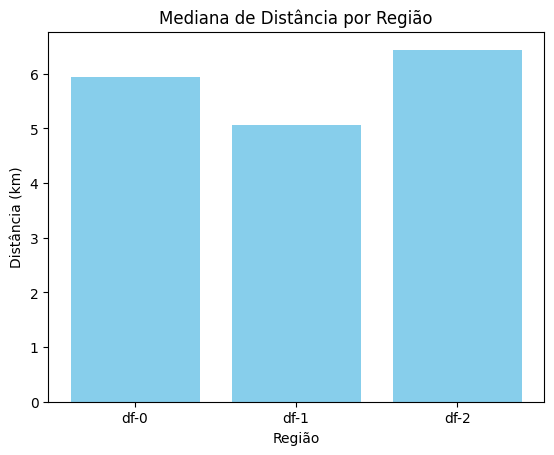

In [44]:
plt.bar(average_distances['region'], average_distances['distance'], color='skyblue')
plt.xlabel('Região')
plt.ylabel('Distância (km)')
plt.title('Mediana de Distância por Região')
plt.show()

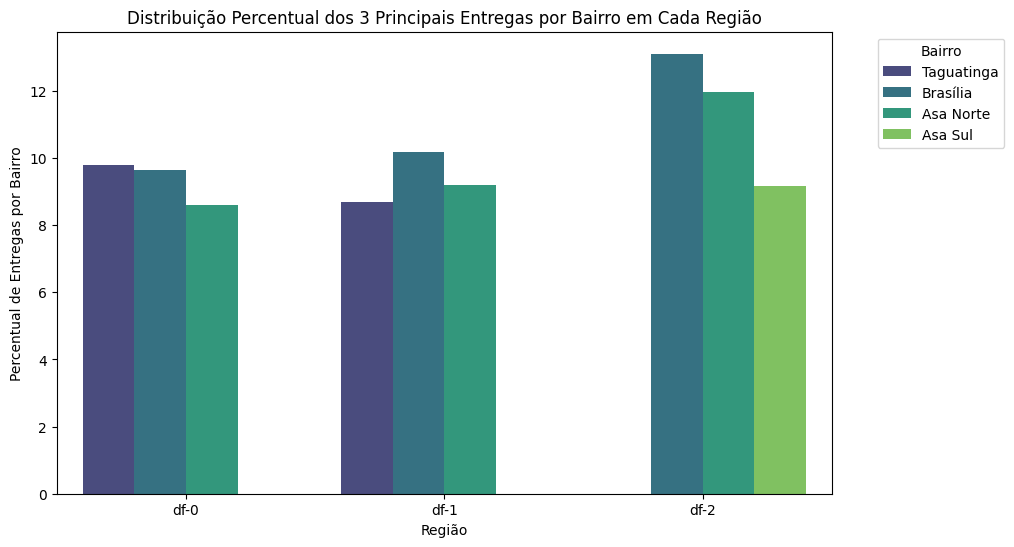

In [41]:
deliveries_count = deliveries_df.groupby(['region', 'delivery_suburb']).size().reset_index(name='count')
total_deliveries_by_hub = deliveries_count.groupby('region')['count'].sum().reset_index(name='total')

# Selecionando os três principais delivery_suburbs por região
top_suburbs_by_region = deliveries_count.groupby('region').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

# Combinando os dados
top_suburbs_by_region = top_suburbs_by_region.merge(total_deliveries_by_hub, on='region')
top_suburbs_by_region['percent'] = 100 * top_suburbs_by_region['count'] / top_suburbs_by_region['total']

# Criando um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='percent', hue='delivery_suburb', data=top_suburbs_by_region, palette='viridis')

plt.xlabel('Região')
plt.ylabel('Percentual de Entregas por Bairro')
plt.title('Distribuição Percentual dos 3 Principais Entregas por Bairro em Cada Região')
plt.legend(title='Bairro', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Insights -

É possível observar que a proporção de entregas realizadas pelos hubs df-1 e df-2 são predominantes frente ao df-0, este último representando pouco mais de 10% do total de entregas. Estes números se devem a dados demográficos e também marcadores sócio-econômicos.

Tomando como base, os dados disponibilizados pela Rede Social das Cidades neste [link](https://www.redesocialdecidades.org.br/br/DF/brasilia/regiao/sia/renda-per-capita-media-mensal://)

A renda mensal na região onde o df-1 está localizado (Brasilia/Plano Piloto) possuí renda mensal per capita de R$ 5.569, sendo essa uma das regiões com maior renda em todo Distrito Federal, o que justificaria o maior uso dos serviços da Loggi por maior incidência de consumo.


Também podemos observar que a região onde está localizdo o hub-0, Sobradinho, além de possuir a menor renda per capita de todos os hubs, se encontra próxima com a região de Itapõa, que possuí renda per capita mensal de R$ 702, ou seja, menos que 5x o valor da renda do bairro do df-1. Sendo assim, o hub df-0 também acaba por atender uma região com menor densidade populacional, o que impacta em sua operação.

Também, pode-se observar que a maior parte de suas entregas são para osbairro de Taguatinga e Brasília/Plano Diretor que também representam um grande percentual das entregas do df-1, sendo assim, é possível que o hub df-0 atue em maior parte como um hub de suporte para dar vazão a grande demanada dessas regiões e assim não comprometa a operçaão do df-1

Também podemos observar que a localização do df-1 também impacta positivamente na distância que os entregadores tem que percorrer, sendo a menor mediana entre os 3 hubs. Isso também impacta para que este se torne o hub com maior volume de entregas.